https://langchain-ai.github.io/langgraph/tutorials/tnt-llm/tnt-llm/

# Text Mining at Scale

TNT-LLM has three main phases:

1. Generate Taxonomy
2. Label Training Data
3. Finetune classifier + deploy


To generate the taxonomy, TNT-LLM proposes 5 steps:

1. **Summarize** chat logs using a lower-cost LLM (batched over all logs in the sample)
2. **Batch** the logs into random minibatches
3. **Generate** an initial taxonomy from the first minibatch
4. **Update** the taxonomy on each subsequent minibatch via a ritique and revise prompt
5. **Review** the final taxonomy, scoring its quality and generating a final value using a final sample.



# Setup

In [2]:
%%capture --no-stderr
%pip install -U langgraph langchain_anthropic langsmith langchain-community
%pip install -U sklearn langchain_openai


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [3]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

# Load environment variables
load_dotenv()
# Set up OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")


# Define the graph

## Graph State

In [4]:
import logging
import operator
from typing import Annotated, List, Optional
from typing_extensions import TypedDict

In [5]:
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("tnt-llm")

In [6]:
class Doc(TypedDict):
    id: str
    content: str
    summary: Optional[str]
    explanation: Optional[str]
    category: Optional[str]

In [7]:
class TaxonomyGenerationState(TypedDict):
    # The raw docs; we inject summaries within them in the first step
    documents: List[Doc]
    # Indices to be concise
    minibatches: List[List[int]]
    # Candidate Taxonomies (full trajectory)
    clusters: Annotated[List[List[dict]], operator.add]

## Define nodes

### 1. Summarize Docs

In [8]:
import re

from langchain import hub
from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnablePassthrough

In [9]:
summary_prompt = hub.pull("wfh/tnt-llm-summary-generation").partial(
    summary_length=20, explanation_length=30
)


c:\Users\DNSOFT\test_notebooks_\.venv\Lib\site-packages\langsmith\client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  


In [10]:
summary_prompt


ChatPromptTemplate(input_variables=['content'], input_types={}, partial_variables={'summary_length': 20, 'explanation_length': 30}, metadata={'lc_hub_owner': 'wfh', 'lc_hub_repo': 'tnt-llm-summary-generation', 'lc_hub_commit_hash': 'fc880e038931afd0ff84bf0191ee75be19aa25a6595bd4d7675f8c12b23685a5'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['content'], input_types={}, partial_variables={}, template='# Instruction\n\n## Context\n- **Goal**: You are tasked with summarizing the input text for the given use case. The summary will represent the input data for clustering in the next step.\n- **Data**: Your input data is a conversation history between a User and an AI agent.\n\n# Data\n<data>\n{content}\n</data>\n'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['explanation_length', 'summary_length'], input_types={}, partial_variables={}, template='# Questions\n## Q1. Summarize the input text in {summary_length} wo

In [11]:
def parse_summary(xml_string: str) -> dict:
    summary_pattern = r"<summary>(.*?)</summary>"
    explanation_pattern = r"<explanation>(.*?)</explanation>"

    summary_match = re.search(summary_pattern, xml_string, re.DOTALL)
    explanation_match = re.search(explanation_pattern, xml_string, re.DOTALL)

    summary = summary_match.group(1).strip() if summary_match else ""
    explanation = explanation_match.group(1).strip() if explanation_match else ""

    return {"summary": summary, "explanation": explanation}

In [12]:
summary_llm_chain = (
    summary_prompt | ChatAnthropic(model="claude-3-haiku-20240307") | StrOutputParser()
    # Customize the tracing name for easier organization
).with_config(run_name="GenerateSummary")
summary_chain = summary_llm_chain | parse_summary

In [14]:
# Now combine as a "map" operation in a map-reduce chain
# Input: state
# Output: state U summaries
# Processes docs in parallel
def get_content(state: TaxonomyGenerationState):
    docs = state["documents"]
    return [{"content": doc["content"]} for doc in docs]

In [15]:
map_step = RunnablePassthrough.assign(
    summaries=get_content
    # This effectively creates a "map" operation
    # Note you can make this more robust by handling individual errors
    | RunnableLambda(func=summary_chain.batch, afunc=summary_chain.abatch)
)

In [17]:
def reduce_summaries(combined: dict) -> TaxonomyGenerationState:
    summaries = combined["summaries"]
    documents = combined["documents"]
    return {
        "documents": [
            {
                "id": doc["id"],
                "content": doc["content"],
                "summary": summ_info["summary"],
                "explanation": summ_info["explanation"],
            }
            for doc, summ_info in zip(documents, summaries)
        ]
    }

In [18]:
# This is actually the node itself!
map_reduce_chain = map_step | reduce_summaries

### 2. Split into Minibatches

In [19]:
import random


def get_minibatches(state: TaxonomyGenerationState, config: RunnableConfig):
    batch_size = config["configurable"].get("batch_size", 200)
    original = state["documents"]
    indices = list(range(len(original)))
    random.shuffle(indices)
    if len(indices) < batch_size:
        # Don't pad needlessly if we can't fill a single batch
        return [indices]

    num_full_batches = len(indices) // batch_size

    batches = [
        indices[i * batch_size : (i + 1) * batch_size] for i in range(num_full_batches)
    ]

    leftovers = len(indices) % batch_size
    if leftovers:
        last_batch = indices[num_full_batches * batch_size :]
        elements_to_add = batch_size - leftovers
        last_batch += random.sample(indices, elements_to_add)
        batches.append(last_batch)

    return {
        "minibatches": batches,
    }

### 3.a Taxonomy Generation Utilities

In [20]:
from typing import Dict

from langchain_core.runnables import Runnable


def parse_taxa(output_text: str) -> Dict:
    """Extract the taxonomy from the generated output."""
    cluster_matches = re.findall(
        r"\s*<id>(.*?)</id>\s*<name>(.*?)</name>\s*<description>(.*?)</description>\s*",
        output_text,
        re.DOTALL,
    )
    clusters = [
        {"id": id.strip(), "name": name.strip(), "description": description.strip()}
        for id, name, description in cluster_matches
    ]
    # We don't parse the explanation since it isn't used downstream
    return {"clusters": clusters}


def format_docs(docs: List[Doc]) -> str:
    xml_table = "<conversations>\n"
    for doc in docs:
        xml_table += f'<conv_summ id={doc["id"]}>{doc["summary"]}</conv_summ>\n'
    xml_table += "</conversations>"
    return xml_table


def format_taxonomy(clusters):
    xml = "<cluster_table>\n"
    for label in clusters:
        xml += "  <cluster>\n"
        xml += f'    <id>{label["id"]}</id>\n'
        xml += f'    <name>{label["name"]}</name>\n'
        xml += f'    <description>{label["description"]}</description>\n'
        xml += "  </cluster>\n"
    xml += "</cluster_table>"
    return xml


def invoke_taxonomy_chain(
    chain: Runnable,
    state: TaxonomyGenerationState,
    config: RunnableConfig,
    mb_indices: List[int],
) -> TaxonomyGenerationState:
    configurable = config["configurable"]
    docs = state["documents"]
    minibatch = [docs[idx] for idx in mb_indices]
    data_table_xml = format_docs(minibatch)

    previous_taxonomy = state["clusters"][-1] if state["clusters"] else []
    cluster_table_xml = format_taxonomy(previous_taxonomy)

    updated_taxonomy = chain.invoke(
        {
            "data_xml": data_table_xml,
            "use_case": configurable["use_case"],
            "cluster_table_xml": cluster_table_xml,
            "suggestion_length": configurable.get("suggestion_length", 30),
            "cluster_name_length": configurable.get("cluster_name_length", 10),
            "cluster_description_length": configurable.get(
                "cluster_description_length", 30
            ),
            "explanation_length": configurable.get("explanation_length", 20),
            "max_num_clusters": configurable.get("max_num_clusters", 25),
        }
    )

    return {
        "clusters": [updated_taxonomy["clusters"]],
    }

### 3. Generate initial taxonomy

In [21]:
# We will share an LLM for each step of the generate -> update -> review cycle
# You may want to consider using Opus or another more powerful model for this
taxonomy_generation_llm = ChatAnthropic(
    model="claude-3-haiku-20240307", max_tokens_to_sample=2000
)


## Initial generation
taxonomy_generation_prompt = hub.pull("wfh/tnt-llm-taxonomy-generation").partial(
    use_case="Generate the taxonomy that can be used to label the user intent in the conversation.",
)

taxa_gen_llm_chain = (
    taxonomy_generation_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="GenerateTaxonomy")


generate_taxonomy_chain = taxa_gen_llm_chain | parse_taxa


def generate_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    return invoke_taxonomy_chain(
        generate_taxonomy_chain, state, config, state["minibatches"][0]
    )

c:\Users\DNSOFT\test_notebooks_\.venv\Lib\site-packages\langsmith\client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  


### 4. Update Taxonomy

In [22]:
taxonomy_update_prompt = hub.pull("wfh/tnt-llm-taxonomy-update")

taxa_update_llm_chain = (
    taxonomy_update_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="UpdateTaxonomy")


update_taxonomy_chain = taxa_update_llm_chain | parse_taxa


def update_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    which_mb = len(state["clusters"]) % len(state["minibatches"])
    return invoke_taxonomy_chain(
        update_taxonomy_chain, state, config, state["minibatches"][which_mb]
    )

c:\Users\DNSOFT\test_notebooks_\.venv\Lib\site-packages\langsmith\client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  


### 5. Review Taxonomy

In [23]:
taxonomy_review_prompt = hub.pull("wfh/tnt-llm-taxonomy-review")

taxa_review_llm_chain = (
    taxonomy_review_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="ReviewTaxonomy")


review_taxonomy_chain = taxa_review_llm_chain | parse_taxa


def review_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    batch_size = config["configurable"].get("batch_size", 200)
    original = state["documents"]
    indices = list(range(len(original)))
    random.shuffle(indices)
    return invoke_taxonomy_chain(
        review_taxonomy_chain, state, config, indices[:batch_size]
    )

c:\Users\DNSOFT\test_notebooks_\.venv\Lib\site-packages\langsmith\client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  


# Compile the Graph

In [24]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(TaxonomyGenerationState)
graph.add_node("summarize", map_reduce_chain)
graph.add_node("get_minibatches", get_minibatches)
graph.add_node("generate_taxonomy", generate_taxonomy)
graph.add_node("update_taxonomy", update_taxonomy)
graph.add_node("review_taxonomy", review_taxonomy)

graph.add_edge("summarize", "get_minibatches")
graph.add_edge("get_minibatches", "generate_taxonomy")
graph.add_edge("generate_taxonomy", "update_taxonomy")


def should_review(state: TaxonomyGenerationState) -> str:
    num_minibatches = len(state["minibatches"])
    num_revisions = len(state["clusters"])
    if num_revisions < num_minibatches:
        return "update_taxonomy"
    return "review_taxonomy"


graph.add_conditional_edges(
    "update_taxonomy",
    should_review,
    # Optional (but required for the diagram to be drawn correctly below)
    {"update_taxonomy": "update_taxonomy", "review_taxonomy": "review_taxonomy"},
)
graph.add_edge("review_taxonomy", END)

graph.add_edge(START, "summarize")
app = graph.compile()

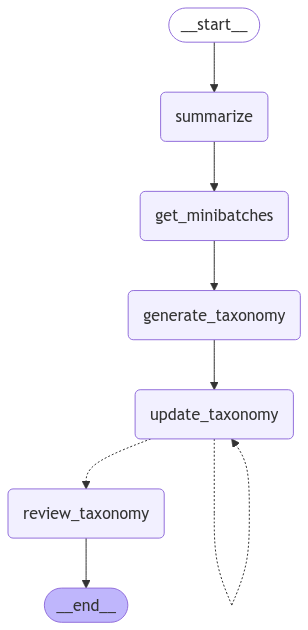

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Use the graph

In [26]:
from datetime import datetime, timedelta

from langsmith import Client

project_name = "YOUR PROJECT NAME"  # Update to your own project
client = Client()

past_week = datetime.now() - timedelta(days=7)
runs = list(
    client.list_runs(
        project_name=project_name,
        filter="eq(is_root, true)",
        start_time=past_week,
        # We only need to return the inputs + outputs
        select=["inputs", "outputs"],
    )
)


# Convert the langsmith traces to our graph's Doc object.
def run_to_doc(run) -> Doc:
    turns = []
    idx = 0
    for turn in run.inputs.get("chat_history") or []:
        key, value = next(iter(turn.items()))
        turns.append(f"<{key} idx={idx}>\n{value}\n</{key}>")
        idx += 1
    turns.append(
        f"""
<human idx={idx}>
{run.inputs['question']}
</human>"""
    )
    if run.outputs and run.outputs["output"]:
        turns.append(
            f"""<ai idx={idx+1}>
{run.outputs['output']}
</ai>"""
        )
    return {
        "id": str(run.id),
        "content": ("\n".join(turns)),
    }

c:\Users\DNSOFT\test_notebooks_\.venv\Lib\site-packages\langsmith\client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  


LangSmithAuthError: Authentication failed for /sessions. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/sessions?limit=1&name=YOUR+PROJECT+NAME&include_stats=False', '{"detail":"Invalid token"}')

In [27]:
import openai

# Replace with your OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")

def ask_openai(prompt):
    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",  # or "gpt-4" depending on your needs
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0.7
        )
        
        # Extract the response text
        answer = response.choices[0].message.content
        return answer
    
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Example usage
if __name__ == "__main__":
    question = "What is the capital of France?"
    response = ask_openai(question)
    print(f"Question: {question}")
    print(f"Answer: {response}")

Question: What is the capital of France?
Answer: An error occurred: Error code: 401 - {'error': {'message': 'The OpenAI account associated with this API key has been deactivated. If you are the developer for this OpenAI app, please check your email for more information. If you are seeing this error while using another app or site, please reach out to them for more help.', 'type': 'invalid_request_error', 'param': None, 'code': 'account_deactivated'}}


In [31]:
import anthropic
import os
from anthropic import Anthropic

def ask_claude(prompt):
    # Initialize the Anthropic client with your API key
    os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")
    client = Anthropic()
    
    try:
        # Create a message
        message = client.messages.create(
            model="claude-3-opus-20240229",
            max_tokens=1000,
            messages=[
                {
                    "role": "user",
                    "content": prompt
                }
            ]
        )
        
        # Print the entire raw response object
        print("Raw Response Object:")
        print(message)
        
        # Print all attributes of the response
        print("\nAll Response Attributes:")
        for attr in dir(message):
            if not attr.startswith('_'):  # Skip internal attributes
                try:
                    print(f"{attr}: {getattr(message, attr)}")
                except:
                    pass
        
        return message.content[0].text
        
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Example usage
if __name__ == "__main__":
    question = "What is the capital of France?"
    response = ask_claude(question)

Raw Response Object:
Message(id='msg_01JmHMthANCqW2tiLELDSecQ', content=[TextBlock(text="The capital of France is Paris.\n\nParis is the country's largest city and is located in the north-central part of France, in the region known as Île-de-France. It is situated on the River Seine and is known for its iconic landmarks, such as the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral.\n\nAs the capital, Paris is the seat of France's national government and is home to the official residence of the President of the French Republic, the Élysée Palace. The city has played a significant role throughout French history and is a major global center for art, fashion, gastronomy, and culture.", type='text')], model='claude-3-opus-20240229', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=14, output_tokens=142))

All Response Attributes:
construct: <bound method BaseModel.constru

# PyMuPDF

In [34]:
!pip install pymupdf


   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
   ----- ---------------------------------- 2.4/16.6 MB 11.2 MB/s eta 0:00:02
   ----------- ---------------------------- 4.7/16.6 MB 11.4 MB/s eta 0:00:02
   ---------------- ----------------------- 6.8/16.6 MB 11.1 MB/s eta 0:00:01
   --------------------- ------------------ 8.9/16.6 MB 10.7 MB/s eta 0:00:01
   --------------------------- ------------ 11.5/16.6 MB 10.9 MB/s eta 0:00:01
   --------------------------------- ------ 13.9/16.6 MB 11.0 MB/s eta 0:00:01
   ---------------------------------------  16.3/16.6 MB 11.0 MB/s eta 0:00:01
   ---------------------------------------- 16.6/16.6 MB 10.6 MB/s eta 0:00:00


In [35]:
from langchain_community.document_loaders import PyMuPDFLoader
loader = PyMuPDFLoader("C:\\Users\\DNSOFT\\Downloads\\Receipt-2960-1788.pdf")

data = loader.load()

In [36]:
data


[Document(metadata={'source': 'C:\\Users\\DNSOFT\\Downloads\\Receipt-2960-1788.pdf', 'file_path': 'C:\\Users\\DNSOFT\\Downloads\\Receipt-2960-1788.pdf', 'page': 0, 'total_pages': 1, 'format': 'PDF 1.4', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Chromium', 'producer': 'Skia/PDF m96', 'creationDate': "D:20240708085704+00'00'", 'modDate': "D:20240708085704+00'00'", 'trapped': ''}, page_content='\xa0\n2960-1788 · $25.13 paid on July 8, 2024\nPage 1 of 1\nReceipt\nInvoice number\n1CA65F3F-0014\nReceipt number\n2960-1788\nDate paid\nJuly 8, 2024\nPayment method Mastercard - 0835\nOpenAI, LLC\n548 Market Street\nPMB 97273\nSan Francisco, California 94104-5401\nUnited States\nar@openai.com\nKR BRN 634-80-02934\nBill to\nJeon HyeonWoo\n서울특별시 seoul\nseoul\nseoul\n08511\nSouth Korea\nKR BRN 108-86-05434\nShip to\nJeon HyeonWoo\n서울특별시 seoul\nseoul\nseoul\n08511\nSouth Korea\n$25.13 paid on July 8, 2024\nDescription\nQty\nUnit price\nAmount\nOpenAI API usage credit\n1\n$

In [38]:
!pip install pymupdf4llm


https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb

In [39]:
import pymupdf4llm


In [40]:
md_text = pymupdf4llm.to_markdown("C:\\Users\\DNSOFT\\Downloads\\Receipt-2960-1788.pdf")


Processing C:\Users\DNSOFT\Downloads\Receipt-2960-1788.pdf...
[                                        ] (0/1=======================================[========================================] (1/1]


In [41]:
md_text


'# p\n\n**Invoice number** **1CA65F3F-0014**\nReceipt number 2960-1788\nDate paid July 8, 2024\nPayment method Mastercard - 0835\n\n**OpenAI, LLC**\n548 Market Street\nPMB 97273\nSan Francisco, California 94104-5401\nUnited States\nar@openai.com\n\nKR BRN 634-80-02934\n\n## $25.13 paid on July 8, 2024\n\n\n**Bill to**\nJeon HyeonWoo\n서울특별시 seoul\nseoul\nseoul\n08511\nSouth Korea\nKR BRN 108-86-05434\n\n\n**Ship to**\nJeon HyeonWoo\n서울특별시 seoul\nseoul\nseoul\n08511\nSouth Korea\n\n\nDescription Qty Unit price Amount\n\nOpenAI API usage credit 1 $25.00 $25.00\n\nSubtotal $25.00\n\nTax to be paid on reverse charge basis\n\nTotal $25.00\n\nApplied balance $0.13\n\n**Amount paid** **$25.13**\n\n\n-----\n\n'

In [47]:
md_text = pymupdf4llm.to_markdown("C:\\Users\\DNSOFT\\Downloads\\2감정-인식과-언어_최원일.pdf")
md_text

Processing C:\Users\DNSOFT\Downloads\2감정-인식과-언어_최원일.pdf...
[                                        ] (0/6=====[======                                  ] (1/6======[=============                           ] (2/======[====================                    ] (3/6=====[==========================              ] (4/6======[=================================       ] (5/======[========================================] (6/6]


'# 감정 지각 과정에서 언어의 역할\n\n광주과학기술원 최원일\n\n정보처리자로서의 인간의 삶에서 언어가 얼마나 중요한 역할을 하는가는 사실 말할 필요가\n\n없다(언어의 중요성에 관해 이야기하면서 ‘말할(언어를 사용할) 필요가 없다’라는 것이 좀 모\n\n순적이지만, 이 표현이 ‘그 정도로 중요하다’의 의미라는 것은 굳이 독자들께 설명해 드릴 필\n\n요가 없는 듯싶다. 앗. 또….). 이러한 언어의 중요성 때문에 인지과학 분야에서는 언어와 수\n\n개념의 관계, 언어와 색 개념의 관계와 같은 언어와 사고의 관계에 관한 연구가 꾸준하게 이\n\n루어져 왔다. 이 글에서는 언어와 감정의 관계, 조금 더 구체적으로 말하면, 언어가 타인의 감\n\n정을 지각하는 데 영향을 미치는가를 살펴보고 그 영향의 성격이 어떤 것인지 알아볼 것이다.\n\n먼저 언어와 사고의 관계에 관한 상당히 급진적인 주장인 벤자민 리 워프(Benjamin Lee\n\nWhorf)의 언어결정론에 관해 알아보자.\n\n**언어결정론: 언어 없이는 사고도 없다!?**\n\n언어결정론은 간단히 말하면 언어가 사고를 주도하고, 우리의 사고방식과 세상을 지각하는\n\n방식은 우리가 사용하는 언어에 의해 결정된다는 가설이다. 사실 언어가 사고에 미치는 영향\n\n에 관해서는 고대 그리스에서 활동했던 소피스트들의 주장까지 거슬러 올라갈 수 있으나, 언\n\n어 없이는 사고도 없다는 강한 언어결정론은 20세기 초반에 활동했던 벤자민 리 워프의 연구\n\n에서 시작되었다고 볼 수 있다. 언어결정론을 뒷받침한다고 알려진 한 예는 워프의 한 연구에\n\n서 찾아볼 수 있는데, 아메리카 원주민인 호피족이 사용하는 언어가 영어를 비롯한 유럽 언어\n\n가 시간을 묘사하는 방식과는 근본적인 차이가 있으며, 이러한 차이가 세계관의 차이를 야기\n\n한다는 것이다. 예를 들어 워프는 호피어에는 시간의 단위를 지칭하는 명사화된 개념이 없으\n\n며, 이는 호피족이 시간을 인식함에 있어 구분된 단위보다는 하나의 통합적인 

In [48]:
md_text


'# 감정 지각 과정에서 언어의 역할\n\n광주과학기술원 최원일\n\n정보처리자로서의 인간의 삶에서 언어가 얼마나 중요한 역할을 하는가는 사실 말할 필요가\n\n없다(언어의 중요성에 관해 이야기하면서 ‘말할(언어를 사용할) 필요가 없다’라는 것이 좀 모\n\n순적이지만, 이 표현이 ‘그 정도로 중요하다’의 의미라는 것은 굳이 독자들께 설명해 드릴 필\n\n요가 없는 듯싶다. 앗. 또….). 이러한 언어의 중요성 때문에 인지과학 분야에서는 언어와 수\n\n개념의 관계, 언어와 색 개념의 관계와 같은 언어와 사고의 관계에 관한 연구가 꾸준하게 이\n\n루어져 왔다. 이 글에서는 언어와 감정의 관계, 조금 더 구체적으로 말하면, 언어가 타인의 감\n\n정을 지각하는 데 영향을 미치는가를 살펴보고 그 영향의 성격이 어떤 것인지 알아볼 것이다.\n\n먼저 언어와 사고의 관계에 관한 상당히 급진적인 주장인 벤자민 리 워프(Benjamin Lee\n\nWhorf)의 언어결정론에 관해 알아보자.\n\n**언어결정론: 언어 없이는 사고도 없다!?**\n\n언어결정론은 간단히 말하면 언어가 사고를 주도하고, 우리의 사고방식과 세상을 지각하는\n\n방식은 우리가 사용하는 언어에 의해 결정된다는 가설이다. 사실 언어가 사고에 미치는 영향\n\n에 관해서는 고대 그리스에서 활동했던 소피스트들의 주장까지 거슬러 올라갈 수 있으나, 언\n\n어 없이는 사고도 없다는 강한 언어결정론은 20세기 초반에 활동했던 벤자민 리 워프의 연구\n\n에서 시작되었다고 볼 수 있다. 언어결정론을 뒷받침한다고 알려진 한 예는 워프의 한 연구에\n\n서 찾아볼 수 있는데, 아메리카 원주민인 호피족이 사용하는 언어가 영어를 비롯한 유럽 언어\n\n가 시간을 묘사하는 방식과는 근본적인 차이가 있으며, 이러한 차이가 세계관의 차이를 야기\n\n한다는 것이다. 예를 들어 워프는 호피어에는 시간의 단위를 지칭하는 명사화된 개념이 없으\n\n며, 이는 호피족이 시간을 인식함에 있어 구분된 단위보다는 하나의 통합적인 

In [49]:
# Write the text to some file in UTF8-encoding
import pathlib
pathlib.Path("output.md").write_bytes(md_text.encode())


20363

In [51]:
md_text = pymupdf4llm.to_markdown("C:\\Users\\DNSOFT\\Downloads\\[AI+튜터]+초등_과학+3-2_1단원-1~2차시_수업+지도안.pdf")


Processing C:\Users\DNSOFT\Downloads\[AI+튜터]+초등_과학+3-2_1단원-1~2차시_수업+지도안.pdf...
[                                        ] (0/2===================[====================                    ] (1/2)

===================[========================================] (2/2]


In [52]:
md_text


'## 과학과 교수・학습 지도안\n\n|Col1|과학과 교수・학|Col3|학습|지도안|Col6|Col7|Col8|Col9|Col10|\n|---|---|---|---|---|---|---|---|---|---|\n|단 원|1. 동물의 생활||대상|3학년 ○반 (○○명)||||||\n||||일시|20○○.○○.○○. (○요일) ○교시|||장소||3학년 ○반 교실|\n|학습 주제|우리 주변에는 어떤 동물이 살까요?||차시|1~2차시|||지도 교사||○ ○ ○|\n|학습 목표|• 학교에서 볼 수 있는 동물을 관찰하고 다양한 동물이 산다는 것을 설명할 수 있다. • 주변에 사는 동물에 대한 흥미와 호기심을 갖는다.||||쪽수||과학 14~15쪽|||\n|교수・학습 자료|교사|교과서, 교과서 음원 및 영상||||||||\n||학생|스마트 패드||||||||\n|지도상 유의점|• 수업 전에 학교에서 동물을 볼 수 있는 장소를 찾아 두고 그중 한곳을 선택하여 동물을 관찰하도록 한다. • 관찰 목적으로 동물을 채집할 때에는 개미나 공벌레처럼 위험하지 않은 동물로 고르고 관찰이 끝나면 살던 곳에 놓아주도록 안내한다. • 관찰할 동물이 다양하지 않을 경우 사진이나 동영상 자료를 활용한다.|||||||||\n|단계|학습 내용|교 수・학 습 활 동||||시간||자료 및 유의점||\n|도입|동기 유발하기 학습 문제 확인하기|▣ 생각 열기 ◦ 다양한 동물을 본 경험 이야기하기 - “우리 주변에는 어떤 동물들이 살고 있을까요?” (예시를 들어 고양이, 참새, 다람쥐 등 언급) ▣ 학습 문제 확인하기 ◦ 주변에서 볼 수 있는 동물을 관찰하고, 다양한 동물이 산다는 것을 설명할 수 있다. ◦ 주변에 사는 동물에 흥미와 호기심을 느낍니다.||||30초||◦ 스마트패드||\n|전개|탐구 활동|[활동1] 주변에서 볼 수 있는 동물 관찰하기 ▣ 동물의 특징에 대해 생각하게 하기 ◦ 학습자의 경험과 동물의 특징 연결짓기 - “ㅇㅇ이는 나와 닮은 동물에 대해 생각해본 적 있나요?” ▣ 관찰한 동물의 

In [53]:
pathlib.Path("output_2.md").write_bytes(md_text.encode())


4261

In [55]:
import pymupdf4llm
from langchain.text_splitter import MarkdownTextSplitter

splitter = MarkdownTextSplitter(chunk_size=80, chunk_overlap=0)

splitter.create_documents([md_text])

[Document(metadata={}, page_content='## 과학과 교수・학습 지도안'),
 Document(metadata={}, page_content='|Col1|과학과 교수・학|Col3|학습|지도안|Col6|Col7|Col8|Col9|Col10|'),
 Document(metadata={}, page_content='|---|---|---|---|---|---|---|---|---|---|\n|단 원|1. 동물의 생활||대상|3학년 ○반 (○○명)||||||'),
 Document(metadata={}, page_content='||||일시|20○○.○○.○○. (○요일) ○교시|||장소||3학년 ○반 교실|'),
 Document(metadata={}, page_content='|학습 주제|우리 주변에는 어떤 동물이 살까요?||차시|1~2차시|||지도 교사||○ ○ ○|'),
 Document(metadata={}, page_content='|학습 목표|• 학교에서 볼 수 있는 동물을 관찰하고 다양한 동물이 산다는 것을 설명할 수 있다. • 주변에 사는 동물에 대한 흥미와 호기심을'),
 Document(metadata={}, page_content='갖는다.||||쪽수||과학 14~15쪽|||'),
 Document(metadata={}, page_content='|교수・학습 자료|교사|교과서, 교과서 음원 및 영상||||||||\n||학생|스마트 패드||||||||'),
 Document(metadata={}, page_content='|지도상 유의점|• 수업 전에 학교에서 동물을 볼 수 있는 장소를 찾아 두고 그중 한곳을 선택하여 동물을 관찰하도록 한다. • 관찰 목적으로'),
 Document(metadata={}, page_content='동물을 채집할 때에는 개미나 공벌레처럼 위험하지 않은 동물로 고르고 관찰이 끝나면 살던 곳에 놓아주도록 안내한다. • 관찰할 동물이 다양하지'),
 Document(metadata={}, page